In [48]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import boto3
import io
import matplotlib.pyplot as plt

BUCKET_NAME = 'tnn-hse-medtech'
ENDPOINT = "https://storage.yandexcloud.net"
PATH_IMAGES = 'datasets/MedicalExpert-I/'
CATERORIES = ['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']
NUM_IMAGES = {'0Normal': 515, '1Doubtful': 478, '2Mild': 233, '3Moderate': 222, '4Severe': 207}

In [2]:
session = boto3.session.Session()

session = boto3.Session(
    aws_access_key_id= os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key= os.getenv('AWS_SECRET_ACCESS_KEY')
)

s3_client = session.client(
    "s3", endpoint_url=ENDPOINT)

In [5]:
def get_image(path_to_image: str, category: str, num_image: int):

    """
    Функция принимает на вход путь до снимков в бакете S3
    Преобразует RGB в Grayscale
    Возвращает numpy массив снимка
    """
    
    file_name = category[1:]+ 'G' + category[0]
    buffer = io.BytesIO()
    s3_client.download_fileobj(BUCKET_NAME, f'{path_to_image}{category}/{file_name} ({num_image}).png', buffer)
    buffer.seek(0)
    image = Image.open(buffer).convert('L')
    return np.array(image)

In [6]:
# все картинки к одному размеру
# эталонный размер - (162, 640)
def padding_image(arr_image, reference_size = (162, 640)):

    """
    Функция принимает картинку
    Возвращает массив numpy приведенный к эталонному размеру
    """

    # arr_image = np.array(image)
    padding = int(round((reference_size[1] - arr_image.shape[1]) / 2))
    padding_arr_image = np.pad(arr_image, ((0, reference_size[0] - arr_image.shape[0]), (padding, padding)))
    return padding_arr_image

In [8]:
def calc_mean_image(category: str, path_images: str):

    """
    Функция принимает на вход категорию снимков и путь до изображений в бакете S3
    Нормализует данные для проявления рельева изображения
    Возвращает средний снимок по категории и его массив
    """

    result_arr_image = np.zeros((162, 640)) # result array with reference size
    dict_count_size_image = dict() # словарь хранит данные о размере всех снимков категории

    # в цикле все изображения категории суммируются
    for i in range(NUM_IMAGES[category] - 1):
        image = get_image(path_images, category, i + 1) # получаем снимок из S3 в виде массива
        arr_im = padding_image(image) # применяем к снимкам паддинг 
        result_arr_image += arr_im
        
        # условие наполняет словарь с количеством уникальных размеров в категории
        if image.shape in dict_count_size_image:
            dict_count_size_image[image.shape] += 1
        else:
            dict_count_size_image[image.shape] = 1

    mean_arr_image = result_arr_image / (NUM_IMAGES[category] - 1)  # среднее значение в категории

    # нормализация
    color_normalize = cv2.normalize(mean_arr_image, 
                                    None, 
                                    alpha = 0, 
                                    beta = 570, 
                                    norm_type = cv2.NORM_MINMAX
                                    )

    color_normalize_arr = np.uint8(color_normalize.astype(int)) # после нормализации к работоспособному формату

    normalize_image = Image.fromarray(color_normalize_arr) # из массива в картинку
    display(normalize_image) # визируем результат 
    return color_normalize_arr, dict_count_size_image

Meam image in 0Normal


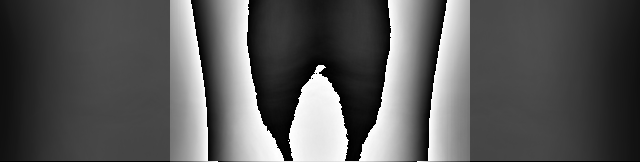

Meam image in 1Doubtful


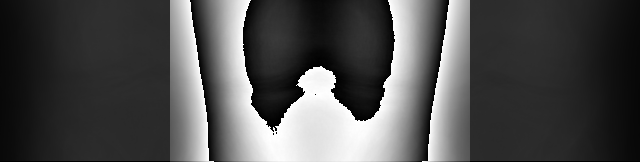

Meam image in 2Mild


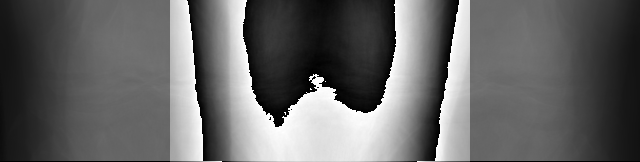

Meam image in 3Moderate


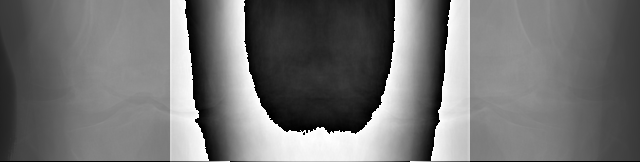

Meam image in 4Severe


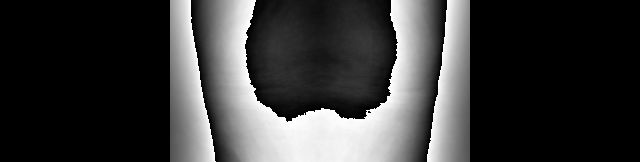

In [13]:
# смотрим итоговые изображения, получаем размеры исходных изображений
dict_sizes = dict() # в словарь собираются размеры снимков в наборе данных
for i in CATERORIES:
    print(f'Meam image in {i}')
    _, sizes = calc_mean_image(i, PATH_IMAGES)
    dict_sizes[i] = sizes


In [47]:
# в датафрейме хранится количество снимков каждого размера по категориям
df = pd.DataFrame(dict_sizes).fillna(0)
df

,,0Normal,1Doubtful,2Mild,3Moderate,4Severe
162,300,452,440,191,175,206.0
161,640,62,37,41,46,0.0
